# Human Detection

# Problem Statement : To detect humans in a image where there are other objects too....

Solution: 

Before detection there are two important things that we need to understand​
​
1. Classification: means that finding an object in a image. ​
​
2. Localization: means to draw bounding box around the image (i.e identify the location of object )​
​
Now, After this we can continue with detection part. Beside these two points discussed above, Suppose there are multiple humans in an image than how you are going to identify multiple humans and how you are going to draw bounding box. So here comes a new algorithm called as sliding window​
​
4. Before Sliding Window: First we need to extract features of human and then train our model. For which let say we have an image of 400x600 size. Image is first preprocessed using some bounding box for human and then cropped into 64x128 colored image and later extract our features of human and non human. We will pass it to svm for prediction using train_test_split.​
​
5. Sliding Window : Now let say you have an test image of 400x600 dimension. What you will do is iterate over image with the size 64x128(in our case) and will extract the feature and pass it to svm and if it predicts human than we will draw bounding box around it​


Result of my Implementation: Yes its detecting my friends so I guess they are human...Took a video from my mobile and executed code on that video and its working !!!  ​
            



In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

Preprocessing Images : 64X128 dimenstion

Took dataset from from ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar 

In [2]:
def resizeImages(image,resX,resY):
    return cv2.resize(image,(resX,resY))
    

In [3]:

human = glob.glob('./Data/INRIAPerson/train_64x128_H96/pos/*.png')
nothuman = glob.glob('./Data/INRIAPerson/train_64x128_H96/neg/*.png')
test=glob.glob('./test_images/*.jpg')
hum=glob.glob('./Data/INRIAPerson/train_64x128_H96/neg/*.png')
for j in hum:
    reim=resizeImages(cv2.imread(j),64,128)
    cv2.imwrite(j, reim)
# for i in hum:
    
#     reim=resizeImages(cv2.imread(i),64,128)
#     cv2.imwrite(i, reim)


## Functions to extract features for detection

1. HoG features
2. Spatial features
3. Histogram features



In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        Visualise=False, feature_vec=True):
    # if visualize is true than it will return features with hog image, else it will return features only
    if Visualise == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=Visualise, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=Visualise, feature_vector=feature_vec)
        #print("hog:", features.shape)
        #print(img.shape)
        return features

# Resizing image to 32 by 32 size and taking it as feature  
def get_spatial_features(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 
    
# returning histograms as feature in all channels
def get_hist_features(img, nbins=32, bins_range=(0, 256)):
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    l=0
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = cv2.imread(file)
# Sift low level features        
#         gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#         sift = cv2.xfeatures2d.SIFT_create()
#         kp ,descp= sift.detectAndCompute(image, None)
#         descp=descp.reshape(-1)
        
#         print(descp.shape)
#         file_features.append(descp)
        # apply color conversion if other than 'RGB'
        feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = get_spatial_features(feature_image, size=spatial_size)
            #print(spatial_features.shape)
            #print(len(spatial_features))
            file_features.append(spatial_features)
            
        if hist_feat == True:
            hist_features = get_hist_features(feature_image, nbins=hist_bins)
            #print("hist")
            #print(len(hist_features))
            file_features.append(hist_features)
            
        if hog_feat == True:
            if hog_channel == 'ALL':# all implies for all channels
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        Visualise=False, feature_vec=True))
#                     print("HOG:", len(hog_features[0]))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, Visualise=False, feature_vec=True)
                
            
#            print(len(hog_features))
            file_features.append(hog_features)
            #print("HOG:", len(hog_features))
       
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    print("Feature Vector Length",len(features[0]))
  
    return features


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    imcopy = np.copy(img)
    # traversing through all the bounding boxes and drawing them
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



## Extracting features for human and not human

In [4]:
# Extracting human and image data
humans = glob.glob('./Data/INRIAPerson/train_64x128_H96/pos/*.png')
nothumans = glob.glob('./Data/INRIAPerson/train_64x128_H96/neg/*.png')

### Defining parameters 
color_space = 'RGB'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # We are taking hog features in all colors
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Taking spatial features
hist_feat = True # Taking histogram features
hog_feat = True # Taking hog features
y_start_stop = [400, None] # minimum and maximum value ,will be used in sliding window


human_features = extract_features(humans, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
nothuman_features = extract_features(nothumans, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


#Normalizing Features

X = np.vstack((human_features, nothuman_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(human_features)), np.zeros(len(nothuman_features))))

/home/rajat/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature Vector Length 12156
Feature Vector Length 12156


## Visualize Training Data
Human and Non-Human Data is shown

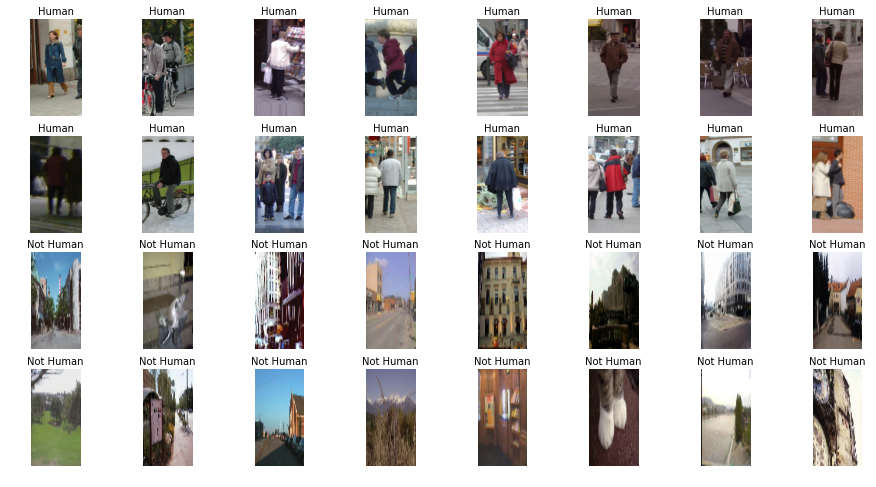

In [5]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(16):
    img = cv2.imread(humans[np.random.randint(0,len(humans))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Human', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(16,32):
    img = cv2.imread(nothumans[np.random.randint(0,len(nothumans))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not Human', fontsize=10)
    axs[i].imshow(img)
    


## Visualize Features

/home/rajat/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


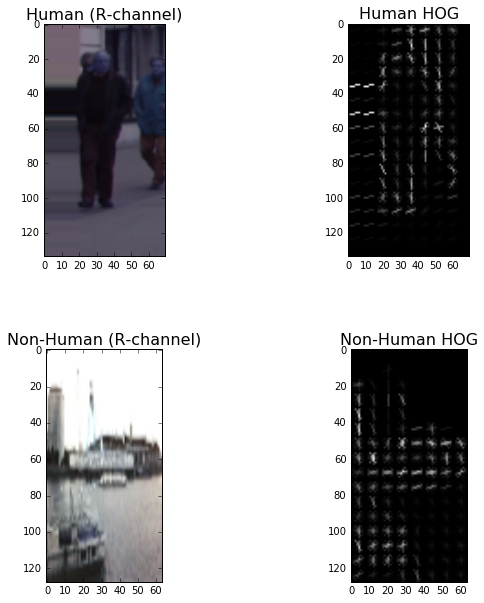

In [6]:
human = cv2.imread(humans[15])

_, human_dst = get_hog_features(human[:,:,0], 9, 8, 2, Visualise=True, feature_vec=True)

nothuman = cv2.imread(nothumans[15])
_, nonhuman_dst = get_hog_features(nothuman[:,:,0], 9, 8, 2, Visualise=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(human)
ax1.set_title('Human (R-channel)', fontsize=16)
ax2.imshow(human_dst, cmap='gray')
ax2.set_title('Human HOG', fontsize=16)
ax3.imshow(nothuman)
ax3.set_title('Non-Human (R-channel)', fontsize=16)
ax4.imshow(nonhuman_dst, cmap='gray')
ax4.set_title('Non-Human HOG', fontsize=16)



Image Histogram

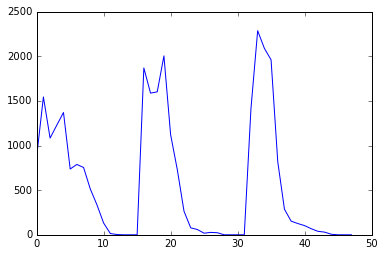

In [7]:
human = cv2.imread(humans[10])
cv2.imwrite("./output_images/sample_human.jpg", human)
hist = get_hist_features(human, nbins=hist_bins)
plt.plot(hist)
plt.show()

## Training a SVM 
1. Spliting data into train and test with test size 20%.
2. Train model using SVM
3. Check accuracy of trained model on test data

In [8]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC

svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


n_predict = 12
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])


Test Accuracy of SVC =  0.9918
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.]
For these 12 labels:  [ 0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.]


## Sliding Window Function and feature extraction
1. Find HOG of scaled image
2. Combine Spatial, histogram and HoG features for each fixed window

In [9]:
def find_humans(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, show_all=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]

    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,128))
            hog1 = get_hog_features(subimg[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel()
            hog2 = get_hog_features(subimg[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel()
            hog3 = get_hog_features(subimg[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel()
            hog_features = np.hstack((hog1, hog2, hog3))

            spatial_features = get_spatial_features(subimg, size=spatial_size)

            hist_features = get_hist_features(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, 
                                                           hog_features)).reshape(1, -1))   

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
  
    return box_list

## Handling False Positives
1. Add all box to generate heatmap
2. Apply threshold to heatmap
3. Draw the filtered boxes

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

 
image = cv2.imread('./test_images/test1.png')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for human_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == human_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Evaluating the complete model on a test image

/home/rajat/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


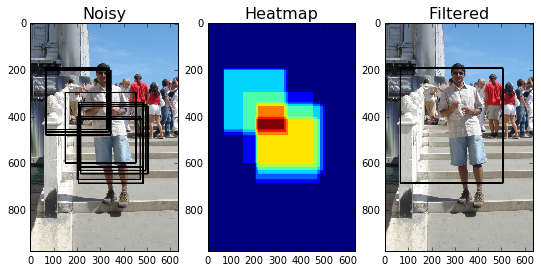

In [11]:
f, ax = plt.subplots(1, 3, figsize=(9,18))
fig.subplots_adjust(hspace = .2, wspace=.001)
ax = ax.ravel()

for i, im in enumerate(glob.glob("./test_images/*")):
    image = mpimg.imread(im)
    box_list = []
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    for scale in np.arange(4,5,0.1):
        ystart = 0
        ystop = 700
    #     scale = 1.5
        box_list += find_humans(image, ystart, ystop, scale, svc, X_scaler, 9, 8, 
                              2, spatial_size, hist_bins,False)

    out_img = draw_boxes(image, box_list)

    heat = add_heat(heat, box_list)
    heat = apply_threshold(heat,0)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    ax[3*i].imshow(out_img)
    ax[3*i].set_title('Noisy', fontsize=16)
    ax[3*i+1].imshow(heat)
    ax[3*i+1].set_title('Heatmap', fontsize=16)
    ax[3*i+2].imshow(draw_img)
    ax[3*i+2].set_title('Filtered', fontsize=16)

f.savefig("./output_images/output_final.png")
    


## Smooth Detection in videos using previously detected boxes

In [12]:
class smooth_detection():
    def __init__(self):
        self.prev_rects = [] 
        
    def combined_box(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

## Defining the complete process
Images from video are fed to this function

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    rectangles = []

    colorspace = 'RGB'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    

    ystart = 0
    ystop = 720
    scale = 4.0
    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))
    
    ystart = 0
    ystop = 720
    scale = 5.0
    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 0
    ystop = 720
    scale = 5.0

    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 0
    ystop = 720
    scale = 4.5
    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 0
    ystop = 720
    scale = 4.5
    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 0
    ystop = 720
    scale = 5.0
    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 0
    ystop = 720
    scale = 4
    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

    ystart = 0
    ystop = 720
    scale = 4
    rectangles.append(find_humans(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,False))

 
    rectangles = [item for sublist in rectangles for item in sublist] 

    if len(rectangles) > 0:
        det.combined_box(rectangles)
    
    heatmap = np.zeros_like(image[:,:,0])
    for rect_set in det.prev_rects:
        heatmap = add_heat(heatmap, rect_set)
    
    a2 = cv2.resize(heatmap, (0,0), fx=0.25, fy=0.25)
    a2 = np.dstack((a2, a2, a2))*255
    
    heatmap_img = apply_threshold(heatmap, 3 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    cv2.putText(draw_img,'Noisy Heatmap',(100,35),1,1.0,[255,255,255],1,cv2.LINE_AA)
    cv2.putText(draw_img,'Label Heatmap',(1045,35),1,1.0,[255,255,255],1,cv2.LINE_AA)
    
    a1 = np.copy(draw_img)
    a3 = cv2.resize(heatmap_img, (0,0), fx=0.25, fy=0.25)
    a3 = np.dstack((a3, a3, a3))*255
    
    a1[50:a2.shape[0]+50,:a2.shape[1],:] = a2
    a1[50:a3.shape[0]+50,3*a3.shape[1]:4*a3.shape[1],:] = a3
    
    return a1

## Human Detection in Videos

In [14]:
det = smooth_detection()

white_output = './output.mp4'
clip1 = VideoFileClip("./2.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4


100%|██████████| 556/556 [15:14<00:00,  1.69s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output.mp4 

CPU times: user 15min 13s, sys: 500 ms, total: 15min 13s
Wall time: 15min 14s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [33]:
det = smooth_detection()

white_output = './output.mp4'
clip1 = VideoFileClip("./3.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4


100%|██████████| 430/430 [11:16<00:00,  1.58s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output.mp4 

CPU times: user 11min 16s, sys: 368 ms, total: 11min 16s
Wall time: 11min 16s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))